# HNCDI Explain: Practical Guide to Quantum Computing

### Install the qiskit library in the colab environment

Please run the below cell to ensure the notebook has qiskit installed.

In [1]:
# Install the qiskit library
%pip install 'qiskit[visualization]'
%pip install qiskit-ibm-runtime
%pip install qiskit-aer


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Tutorial 2: Estimate $\pi$ using quantum algorithms

In [2]:
import numpy as np
from qiskit.visualization import *
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile
from qiskit_aer.primitives import SamplerV2
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as real_sampler
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
import matplotlib.pyplot as plt

In [3]:
# Set simulator backend
sampler = AerSimulator()

## Approximating $\pi$ 

In [4]:
#Compute the Inverse Quantum Fourier Transform

def qft_dagger(circ_, n_qubits):
    """n-qubit QFTdagger the first n qubits in circ"""
    for qubit in range(int(n_qubits/2)):
        circ_.swap(qubit, n_qubits-qubit-1)
    for j in range(0,n_qubits):
        for m in range(j):
            circ_.cp(-np.pi/float(2**(j-m)), m, j)
        circ_.h(j)

In [5]:
#Initial state of Quantum Phase Estimation

def qpe_pre(circ_, n_qubits):
    circ_.h(range(n_qubits))
    circ_.x(n_qubits)

    for x in reversed(range(n_qubits)):
        for _ in range(2**(n_qubits-1-x)):
            circ_.cp(1, n_qubits-1-x, n_qubits)

In [6]:
def run_job(circ, backend, shots, optimization_level=0):
    t_circ = transpile(circ, backend, optimization_level=optimization_level, coupling_map=None)
    # qobj = assemble(t_circ, shots=shots)
    job = backend.run(t_circ)
    result = job.result()
    return result

In [7]:
def get_pi_estimate(n_qubits, backend, shots):
        
    # create the circuit
    circ = QuantumCircuit(n_qubits + 1, n_qubits)
    
    # create the input state
    qpe_pre(circ, n_qubits)
        
    # apply a barrier
    circ.barrier()
    # apply the inverse fourier transform
    qft_dagger(circ, n_qubits)
    # apply  a barrier
    circ.barrier()
    # measure all but the last qubits
    circ.measure(range(n_qubits), range(n_qubits))
    
    # optionally save to a file
    if n_qubits == 3:
        circ.draw(filename='qpe')

    # run the job and get the results
    job_results = run_job(circ, backend, shots, optimization_level=0)
    
    # Extract the counts from the result
    if(type(backend) is SamplerV2):
        result = job_results[0].data.c
        counts = result.get_counts()
    else:
        counts = job_results.get_counts()
        
    print('counts = ', counts) 

    # get the count that occurred most frequently
    max_counts_result = max(counts, key=counts.get)
    print('max_counts_result = ', max_counts_result)
    max_counts_result = int(max_counts_result, 2)
    print('max_counts_result = ', max_counts_result)
    
    # solve for pi from the measured counts
    theta = max_counts_result/2**n_qubits
    return (1./(2*theta))

In [8]:
# estimate pi using different numbers of qubits

number_of_shots = 1024
upper_limit_qubits = 3 # Add an upper limit of qubits
nqs = list(range(2,upper_limit_qubits+1))
pi_estimates = []
for nq in nqs:
    thisnq_pi_estimate = get_pi_estimate(nq, sampler, number_of_shots)
    pi_estimates.append(thisnq_pi_estimate)
    print(f"{nq} qubits, pi ≈ {thisnq_pi_estimate}")

counts =  {'11': 71, '10': 60, '00': 198, '01': 695}
max_counts_result =  01
max_counts_result =  1
2 qubits, pi ≈ 2.0
counts =  {'101': 3, '011': 20, '111': 18, '010': 110, '000': 48, '100': 15, '110': 14, '001': 796}
max_counts_result =  001
max_counts_result =  1
3 qubits, pi ≈ 4.0


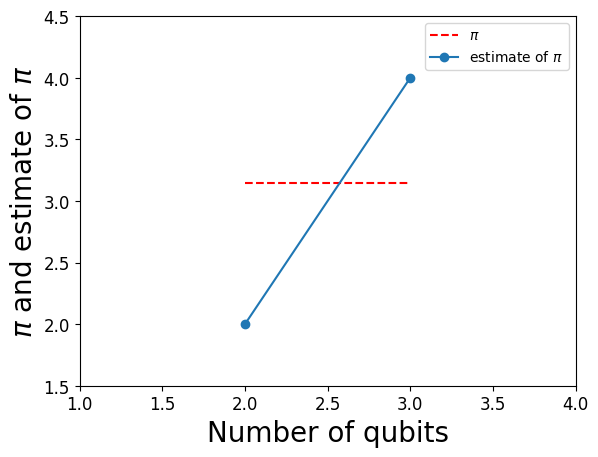

In [9]:
pi = np.pi

plt.plot(nqs, [pi]*len(nqs), '--r')
plt.plot(nqs, pi_estimates, '.-', markersize=12)
plt.xlim([nqs[0]-1,nqs[-1]+1])
plt.ylim([1.5, 4.5])
plt.legend(['$\pi$', 'estimate of $\pi$'])
plt.xlabel('Number of qubits', fontdict={'size':20})
plt.ylabel('$\pi$ and estimate of $\pi$', fontdict={'size':20})
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.show()